In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [2]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [4]:
df.shape

(17414, 10)

In [5]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:17414, 1:2]

In [6]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


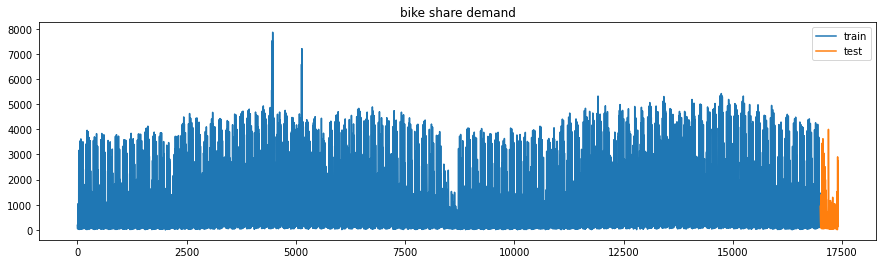

In [7]:
df['cnt'][:17000].plot(figsize=(15,4), legend=True)
df['cnt'][17000:].plot(figsize=(15,4), legend=True)
plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

In [8]:
# 차수 추정

from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=42, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713  0.13216383  0.36316314  0.36823577
  0.17363431 -0.40134782  0.25244062 -0.0346957   0.06394955  0.0401744
  0.03309681 -0.05199095 -0.14022104 -0.13320839  0.08181519 -0.01496363
 -0.04990686 -0.03495871 -0.01086392  0.04519191  0.01509356  0.03339241
  0.09344723]


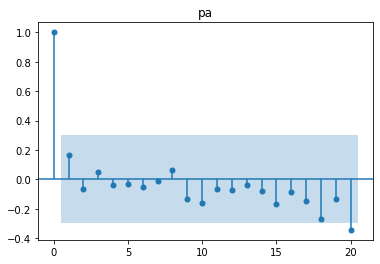

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=20, method='ols', title='pa').show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [11]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [12]:
X_train = []
y_train = []

for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(16999, 1)

In [14]:
# 3차원 배열로 reshape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)